Write a Python program that reads the TaxiFare.csv(provided on LMS) file into  a  DataFrame  and  build  a  good  random  forest  model  by  performing the following tasks:

1.Load the TaxiFare.csvdataset into a DataFrame

2.Drop ‘unique_id’, and find missing values from the dataset

3.Convert the ‘date_time_of_pickup’ column to date and time format and  extract  information  and  create  new  columns  as  ‘hour‘, ‘dayOfTheMonth’,’ month’,   ‘dayOfTheWeek’.

4.Find   traveling   distance   based   on   given   coordinates   using   the "Haversine" distance formula and create anew column as ‘distance’ and store the data.Note:The  Haversine  formula  calculates  the  shortest  distance  between two  points  on  a  sphere  using  their  latitudes  and  longitudes  measured along the surface. It is important for use in navigation  
r is radius of earth i.e 6371 KM or 3961 milesand d is the distance computed between two points

5.Eliminate some anomalous/outlier data based on certain "Domain" logic

5A.Amount < 2.5 as the minimum fare is 2

5B.Trips with travel distance less than or equal to 1, and more than 130 Kms. Let’s say this was a condition provided by clients based on travel range.

6.Extract independent variables (Xs) and dependent variables (Ys) into separate data objects

7.Find important features using random forest.

8.Build  a  model  and  predict  the  result  for  the  test  dataset  based  on MAPE and RMSE.Dataset:


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from io import StringIO
%matplotlib inline

In [ ]:
d=pd.read_csv("/content/TaxiFare.csv")
d.head()

,unique_id,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,amount
0,26:21.0,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,4.5
1,52:16.0,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,16.9
2,35:00.0,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,5.7
3,30:42.0,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,7.7
4,51:00.0,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,5.3


2.Drop ‘unique_id’, and find missing values from the dataset

In [ ]:
df=d.drop(['unique_id'],axis=1)
df.head()
print(df.isnull().sum())

date_time_of_pickup     0
longitude_of_pickup     0
latitude_of_pickup      0
longitude_of_dropoff    0
latitude_of_dropoff     0
no_of_passenger         0
amount                  0
dtype: int64


3.Convert the ‘date_time_of_pickup’ column to date and time format and extract information and create new columns as ‘hour‘, ‘dayOfTheMonth’,’ month’, ‘dayOfTheWeek’.

In [ ]:

df['date_time_of_pickup'] = pd.to_datetime(df['date_time_of_pickup'])
df['hour'] = df['date_time_of_pickup'].dt.hour
df['dayOfTheMonth'] = df['date_time_of_pickup'].dt.day
df['month'] = df['date_time_of_pickup'].dt.month
df['dayOfTheWeek'] = df['date_time_of_pickup'].dt.dayofweek
df.head()


,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,amount,hour,dayOfTheMonth,month,dayOfTheWeek
0,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,4.5,17,15,6,0
1,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16.9,16,5,1,1
2,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,5.7,0,18,8,3
3,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,7.7,4,21,4,5
4,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,5.3,7,9,3,1


In [ ]:
data=df.drop(['date_time_of_pickup'],axis=1)

In [ ]:
data.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,amount,hour,dayOfTheMonth,month,dayOfTheWeek
0,-73.844311,40.721319,-73.841610,40.712278,1,4.5,17,15,6,0
1,-74.016048,40.711303,-73.979268,40.782004,1,16.9,16,5,1,1
2,-73.982738,40.761270,-73.991242,40.750562,2,5.7,0,18,8,3
3,-73.987130,40.733143,-73.991567,40.758092,1,7.7,4,21,4,5
4,-73.968095,40.768008,-73.956655,40.783762,1,5.3,7,9,3,1


4.Find traveling distance based on given coordinates using the "Haversine" distance formula and create anew column as ‘distance’ and store the data.Note:The Haversine formula calculates the shortest distance between two points on a sphere using their latitudes and longitudes measured along the surface. It is important for use in navigation
r is radius of earth i.e 6371 KM or 3961 milesand d is the distance computed between two points

In [ ]:
def haversine(lon1, lat1, lon2, lat2):

    R = 6367


    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])


    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

In [ ]:
data['distance'] = data.apply(lambda row: haversine(row['longitude_of_pickup'], row['latitude_of_pickup'], row['longitude_of_dropoff'], row['latitude_of_dropoff']), axis=1)


In [ ]:
data.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,amount,hour,dayOfTheMonth,month,dayOfTheWeek,distance
0,-73.844311,40.721319,-73.841610,40.712278,1,4.5,17,15,6,0,1.030117
1,-74.016048,40.711303,-73.979268,40.782004,1,16.9,16,5,1,1,8.444828
2,-73.982738,40.761270,-73.991242,40.750562,2,5.7,0,18,8,3,1.388653
3,-73.987130,40.733143,-73.991567,40.758092,1,7.7,4,21,4,5,2.797513
4,-73.968095,40.768008,-73.956655,40.783762,1,5.3,7,9,3,1,1.997902


5.Eliminate some anomalous/outlier data based on certain "Domain" logic

5A.Amount < 2.5 as the minimum fare is 2

5B.Trips with travel distance less than or equal to 1, and more than 130 Kms. Let’s say this was a condition provided by clients based on travel range.

In [ ]:
condition_a =(data['distance'] >=1)
condition_b = (data['distance'] <= 130)
filtered_data = data[condition_a & condition_b]
filtered_data.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,amount,hour,dayOfTheMonth,month,dayOfTheWeek,distance
0,-73.844311,40.721319,-73.841610,40.712278,1,4.5,17,15,6,0,1.030117
1,-74.016048,40.711303,-73.979268,40.782004,1,16.9,16,5,1,1,8.444828
2,-73.982738,40.761270,-73.991242,40.750562,2,5.7,0,18,8,3,1.388653
3,-73.987130,40.733143,-73.991567,40.758092,1,7.7,4,21,4,5,2.797513
4,-73.968095,40.768008,-73.956655,40.783762,1,5.3,7,9,3,1,1.997902


In [ ]:

filtered_data.shape


(40926, 11)


6.Extract independent variables (Xs) and dependent variables (Ys) into separate data objects

In [ ]:
x=filtered_data.drop(['amount'],axis=1).copy()
y=filtered_data['amount'].copy()

In [ ]:
x.isnull().sum()

longitude_of_pickup     0
latitude_of_pickup      0
longitude_of_dropoff    0
latitude_of_dropoff     0
no_of_passenger         0
hour                    0
dayOfTheMonth           0
month                   0
dayOfTheWeek            0
distance                0
dtype: int64

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=100)

7.Find important features using random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=123)
rf_model.fit(x_train,y_train)
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Variable':x_train.columns,'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head()

,Variable,Importance
9,distance,0.833108
2,longitude_of_dropoff,0.046062
3,latitude_of_dropoff,0.033203
0,longitude_of_pickup,0.026619
1,latitude_of_pickup,0.019757


In [ ]:
testpred=pd.DataFrame()
testpred['Predction']=rf_model.predict(x_test)
testpred['Actual']=y_test.values
testpred.head()


,Predction,Actual
0,13.2817,15.5
1,9.1810,10.0
2,8.3820,8.0
3,6.1400,5.0
4,15.7530,21.0


8.Build a model and predict the result for the test dataset based on MAPE and RMSE

In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred = rf_model.predict(x_test)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mape = calculate_mape(y_test, y_pred)
rmse = calculate_rmse(y_test, y_pred)

print(f'MAPE:', mape)
print(f'RMSE: ',rmse)





MAPE: 18.924176905704467
RMSE:  4.249447879749447


Write  a  Python  program  that  reads  the  h1n1_vaccine_prediction.csv (provided on LMS) file into a DataFrame and build a good random forest model by performing the following tasks:

1.Load the h1n1_vaccine_prediction.csv dataset into a DataFrame

2.Do  value  count  for  the  dependent  variable,  and  check  if the data  is imbalanced or not.

3.Drop columns that have more than 50% missing data. And then drop all null values

4.Print a Bar plot for the dependent variable for all categories

5.Do label encoding for all categorical features

6.Extract independent variables (Xs) and dependent variables (Ys) into separate data objects

7.Build a random forest model and evaluate it on test data.

8.Do oversample and then build another random forest model for test data and compare their accuracy

In [ ]:
pip install imblearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing  import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from matplotlib.colors import ListedColormap
from sklearn import metrics
import seaborn as sns

In [ ]:
df=pd.read_csv('/content/h1n1_vaccine_prediction.csv')
df.head()

,unique_id,h1n1_worry,h1n1_awareness,antiviral_medication,contact_avoidance,bought_face_mask,wash_hands_frequently,avoid_large_gatherings,reduced_outside_home_cont,avoid_touch_face,...,race,sex,income_level,marital_status,housing_status,employment,census_msa,no_of_adults,no_of_children,h1n1_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,Non-MSA,0.0,0.0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,"MSA, Not Principle City",0.0,0.0,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,"MSA, Not Principle City",2.0,0.0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,"MSA, Principle City",0.0,0.0,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",1.0,0.0,0


2.Do  value  count  for  the  dependent  variable,  and  check  if the data  is imbalanced or not.

In [ ]:
df['h1n1_vaccine'].value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

In [ ]:
df.shape

(26707, 34)

In [ ]:
df.isnull().sum()

unique_id                        0
h1n1_worry                      92
h1n1_awareness                 116
antiviral_medication            71
contact_avoidance              208
bought_face_mask                19
wash_hands_frequently           42
avoid_large_gatherings          87
reduced_outside_home_cont       82
avoid_touch_face               128
dr_recc_h1n1_vacc             2160
dr_recc_seasonal_vacc         2160
chronic_medic_condition        971
cont_child_undr_6_mnths        820
is_health_worker               804
has_health_insur             12274
is_h1n1_vacc_effective         391
is_h1n1_risky                  388
sick_from_h1n1_vacc            395
is_seas_vacc_effective         462
is_seas_risky                  514
sick_from_seas_vacc            537
age_bracket                      0
qualification                 1407
race                             0
sex                              0
income_level                  4423
marital_status                1408
housing_status      

.Drop columns that have more than 50% missing data. And then drop all null values

In [ ]:
df.isnull().sum()/len(df)*100

unique_id                     0.000000
h1n1_worry                    0.344479
h1n1_awareness                0.434343
antiviral_medication          0.265848
contact_avoidance             0.778822
bought_face_mask              0.071142
wash_hands_frequently         0.157262
avoid_large_gatherings        0.325757
reduced_outside_home_cont     0.307036
avoid_touch_face              0.479275
dr_recc_h1n1_vacc             8.087767
dr_recc_seasonal_vacc         8.087767
chronic_medic_condition       3.635751
cont_child_undr_6_mnths       3.070356
is_health_worker              3.010447
has_health_insur             45.957989
is_h1n1_vacc_effective        1.464036
is_h1n1_risky                 1.452803
sick_from_h1n1_vacc           1.479013
is_seas_vacc_effective        1.729884
is_seas_risky                 1.924589
sick_from_seas_vacc           2.010709
age_bracket                   0.000000
qualification                 5.268282
race                          0.000000
sex                      

In [ ]:
df2=df.drop(['has_health_insur'],axis=1)
df2=df2.dropna()
df2.shape

(19642, 33)

4.Print a Bar plot for the dependent variable for all categorie

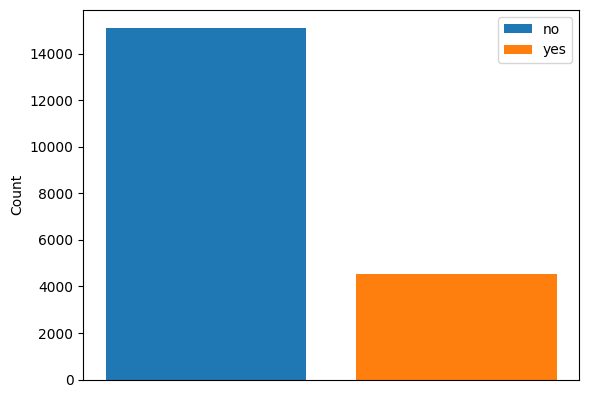

In [ ]:
x1=df2[df2.h1n1_vaccine==0].h1n1_vaccine.count()
x2=df2[df2.h1n1_vaccine==1].h1n1_vaccine.count()
plt.bar(0,x1,label='no')
plt.bar(1,x2,label='yes')
plt.xticks([])
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   unique_id                  26707 non-null  int64  
 1   h1n1_worry                 26615 non-null  float64
 2   h1n1_awareness             26591 non-null  float64
 3   antiviral_medication       26636 non-null  float64
 4   contact_avoidance          26499 non-null  float64
 5   bought_face_mask           26688 non-null  float64
 6   wash_hands_frequently      26665 non-null  float64
 7   avoid_large_gatherings     26620 non-null  float64
 8   reduced_outside_home_cont  26625 non-null  float64
 9   avoid_touch_face           26579 non-null  float64
 10  dr_recc_h1n1_vacc          24547 non-null  float64
 11  dr_recc_seasonal_vacc      24547 non-null  float64
 12  chronic_medic_condition    25736 non-null  float64
 13  cont_child_undr_6_mnths    25887 non-null  flo

6.Extract independent variables (Xs) and dependent variables (Ys) into separate data objects

In [ ]:
from sklearn import preprocessing
lb=preprocessing.LabelEncoder()
df2.qualification=lb.fit_transform(df2.qualification.values)
df2. age_bracket=lb.fit_transform(df2.age_bracket.values)
df2. race=lb.fit_transform(df2.race.values)
df2.  sex=lb.fit_transform(df2. sex.values)
df2. income_level=lb.fit_transform(df2.income_level.values)
df2.  marital_status=lb.fit_transform(df2. marital_status.values)
df2.  housing_status=lb.fit_transform(df2. housing_status.values)
df2. employment=lb.fit_transform(df2.employment.values)
df2. census_msa=lb.fit_transform(df2.census_msa.values)



In [ ]:
x=df2.drop('h1n1_vaccine' ,axis=1)
y=df2['h1n1_vaccine']


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(x_train.size)

(15713, 32)
(3929, 32)
(15713,)
(3929,)
502816


7.Build a random forest model and evaluate it on test data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print()
score1=metrics.accuracy_score(y_test,y_pred)
print('accuracy of the model :',metrics.accuracy_score(y_test,y_pred))


accuracy of the model : 0.827691524560957


In [ ]:
from imblearn.over_sampling import SMOTE
oversample=SMOTE()
x_smote,y_smote=oversample.fit_resample(x,y)

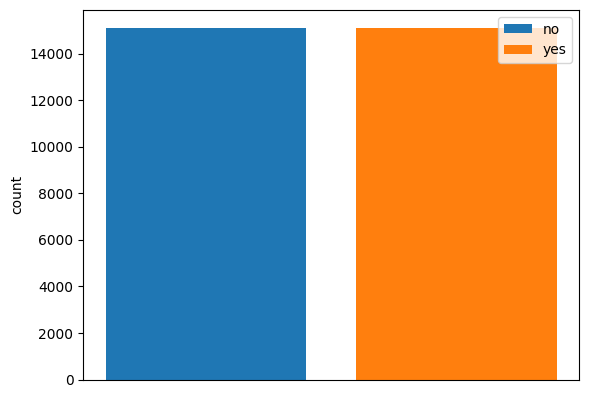

In [ ]:
pur=y_smote[y_smote==0].count()
notpur=y_smote[y_smote==1].count()
plt.bar(0,pur,label="no")
plt.bar(1,notpur,label='yes')
plt.xticks([])
plt.ylabel('count')
plt.legend()
plt.show()

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.20)

Do over sample and then build another random forest model for test data and compare their accuracy

In [ ]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
from sklearn import metrics
print()
score2 =  metrics.accuracy_score(y_test, y_pred)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.8856576338400529


In [ ]:
print("before smot accuracy is:",score1)
print("after smot accuracy is:",score2)


before smot accuracy is: 0.827691524560957
after smot accuracy is: 0.8856576338400529
